In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from numba import jit

%matplotlib inline

In [1857]:
class DecisionTree(object):
    def __init__(self, max_depth=None, root=None):
        self.left_child = None
        self.right_child = None
        self.predicate = None
        self.predicate_value = None
        self.max_depth = max_depth
        self.output = None
        self.leaf_number = None
        self.root = root
        self.n_leafs = 0
        self.leafs = []
        if root is None:
            self.root = self

    @staticmethod
    @jit(nopython=True)
    def best_split_jit(x, y, sort_index):
        n = sort_index.shape[1]
        mean = np.mean(y[sort_index[0]])
        smean = np.sum((y[sort_index[0]]-mean)**2)
        best_feat = 0
        best_val = x[sort_index[0, 0], 0]
        min_gain = smean

        for i in xrange(x.shape[1]):
        
            cur_ind = sort_index[i]
            y1 = y[cur_ind]
            x1 = x[cur_ind, i]

            mean_l = 0.0
            mean_r = mean
            smean_l = 0.0
            smean_r = smean
            imp_left =None
            imp_right = None
            
            for j in xrange(n-1):
                delta = y1[j] - mean_l
                mean_l = mean_l + delta / (j+1.0)
                delta2 = y1[j] - mean_l
                smean_l = smean_l + delta * delta2
                
                delta = y1[j] - mean_r
                mean_r = mean_r - delta / (n-j-1.0)
                delta2 = y1[j] - mean_r
                smean_r = smean_r - delta * delta2

                imp_left = smean_l
                imp_right = smean_r

                gain = imp_left + imp_right
                if gain < min_gain and x1[j] != x1[j+1]:
                    min_gain = gain
                    best_feat = i
                    best_val = (x1[j] + x1[j+1]) / 2.0

        return best_feat, best_val

    @staticmethod
    def best_split(x, y, sort_index):
        best_feat, best_val = DecisionTree.best_split_jit(x, y, sort_index)
        ind = sort_index[best_feat][x[sort_index[best_feat], best_feat] < best_val]
        mask = np.zeros_like(sort_index, dtype=bool)
        for i in xrange(x.shape[1]):
            mask[i] = np.isin(sort_index[i], ind, assume_unique=True)
        
        return sort_index[mask].reshape(x.shape[1], -1), sort_index[~mask].reshape(x.shape[1], -1), best_feat, best_val

    def fit(self, x, y, sort_index=None):
        if not (isinstance(x, np.ndarray) and isinstance(y, np.ndarray)):
            print 'x and y should be np.ndarray'
            return

        if sort_index is None:
            sort_index = np.asarray(np.argsort(x, axis=0).T)

        if self.max_depth == 0 or sort_index.shape[1] == 1:
            self.output = np.mean(y[sort_index[0]])
            self.leaf_number = self.root.n_leafs
            self.root.n_leafs += 1
            self.root.leafs.append(self)
            return self

        sort_index1, sort_index2, self.predicate, self.predicate_value = self.best_split(x, y, sort_index)
        
        if sort_index1.shape[1] == 0 or sort_index2.shape[1] == 0:
            self.output = np.mean(y[sort_index[0]])
            self.leaf_number = self.root.n_leafs
            self.root.n_leafs += 1
            self.root.leafs.append(self)
            return self
        
        if self.max_depth is not None:
            self.left_child = DecisionTree(max_depth=self.max_depth-1, root=self.root).fit(x, y, sort_index1)
            self.right_child = DecisionTree(max_depth=self.max_depth-1, root=self.root).fit(x, y, sort_index2)
        else:
            self.left_child = DecisionTree(root=self.root).fit(x, y, sort_index1)
            self.right_child = DecisionTree(root=self.root).fit(x, y, sort_index2)

        return self

    def __predict__(self, x):
        if self.output is not None:
            return self.output
        if x[self.predicate] < self.predicate_value:
            return self.left_child.__predict__(x)
        else:
            return self.right_child.__predict__(x)

    def predict(self, x):
        y_pred = np.zeros(x.shape[0])
        for i, xx in enumerate(x):
            y_pred[i] = self.__predict__(xx)
        return y_pred

    def get_leaf(self, x):
        if self.leaf_number is not None:
            return self.leaf_number
        if x[self.predicate] < self.predicate_value:
            return self.left_child.get_leaf(x)
        else:
            return self.right_child.get_leaf(x)

In [1886]:
x_true = np.arange(-5, 5, 0.002)
x = x_true + np.random.rand(x_true.shape[0]) - 0.5
y_true = np.sin(x_true)+x_true/3
y = y_true + np.random.rand(x_true.shape[0]) - 0.5

In [1887]:
tree = DecisionTree(max_depth=5)

In [1888]:
%time tree.fit(x.reshape(-1,1), y)

CPU times: user 8.36 ms, sys: 3.25 ms, total: 11.6 ms
Wall time: 8.5 ms


In [1889]:
%time y_hat = tree.predict(x_true.reshape(-1,1))

CPU times: user 28.5 ms, sys: 9.75 ms, total: 38.2 ms
Wall time: 29.2 ms


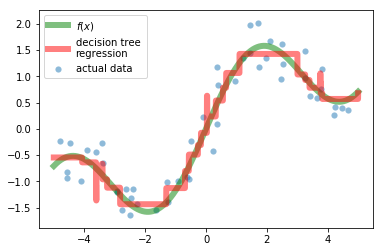

In [1890]:
plt.plot(x_true, y_true, c='g', label='$f(x)$', linewidth=6, alpha=0.5)
plt.scatter(x[::100], y[::100], linewidths=0.1, label='actual data', alpha=0.5)
plt.plot(x_true, y_hat, c='r', label='decision tree \nregression', linewidth=6, alpha=0.5)
plt.legend(loc=2)

### sklearn cart

In [1891]:
tree = DecisionTreeRegressor(max_depth=5)

In [1892]:
%time tree.fit(x.reshape(-1,1), y)

CPU times: user 5.32 ms, sys: 1.73 ms, total: 7.05 ms
Wall time: 5.06 ms


DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [1893]:
%time y_hat = tree.predict(x_true.reshape(-1,1))

CPU times: user 696 µs, sys: 358 µs, total: 1.05 ms
Wall time: 640 µs


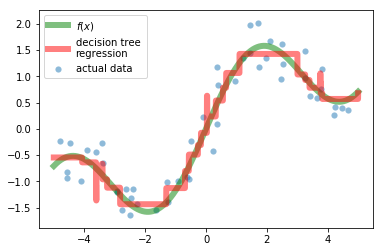

In [1894]:
plt.plot(x_true, y_true, c='g', label='$f(x)$', linewidth=6, alpha=0.5)
plt.scatter(x[::100], y[::100], linewidths=0.1, label='actual data', alpha=0.5)
plt.plot(x_true, y_hat, c='r', label='decision tree \nregression', linewidth=6, alpha=0.5)
plt.legend(loc=2)

### Boosting

In [1958]:
import sys

class BernoulliConst(object):
    def __init__(self):
        self.base = None
    def fit(self, x, y, *args):
        self.base = 0.5*(np.log(1 + np.mean(y)) - np.log(1 - np.mean(y)))
        return self
    def predict(self, x, *args):
        return np.ones(x.shape[0]).reshape(-1, 1)*self.base
    
class GBoosting(object):
    def __init__(self, max_depth=None, n_iters=10, lr=0.1, init=BernoulliConst()):
        self.max_depth = max_depth
        self.n_iters = n_iters
        self.trees = []
        self.lr = lr
        self.init = init
        
    @staticmethod
    @jit(nopython=True)
    def calc_new_out(y_hi):
        return np.sum(y_hi) / np.sum(np.abs(y_hi)*(2.0 - np.abs(y_hi)))
    
    def fit(self, x, y):
        self.init.fit(x, y)
        f_m = self.init.predict(x).reshape(-1)
        
        for i in xrange(self.n_iters):
            sys.stdout.write("\r"+"iter "+str(i))
            
            y_h = 2.0*y/(1.0 + np.exp(2.0*y*f_m))
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(x, y_h)
            self.trees.append(tree)
            
            leafs_numbers = np.zeros_like(y, dtype=int)
            for j, xx in enumerate(x):
                leafs_numbers[j] = tree.get_leaf(xx)
            
            for leaf in tree.leafs:
                ind = leafs_numbers == leaf.leaf_number
                y_hi = y_h[ind] 
                leaf.output = self.lr*self.calc_new_out(y_hi)
                
            f_m += tree.predict(x)

        return self
    
    @staticmethod
    def loss_fn(y, f):
        return np.sum(np.log(1.0+np.exp(-2.0*y*f)))

    def predict(self, x):
        y = self.init.predict(x).reshape(-1) + np.sum(tree.predict(x) for tree in self.trees)
        y_prob = 1.0 / (1 + np.exp(-2.0*y))
        return 2*np.array(y_prob > 0.5, dtype=int) - 1
    
    def staged_predict(self, x):
        y = self.init.predict(x).reshape(-1)
        y_prob = 1.0 / (1 + np.exp(-2.0*y))
        for tree in self.trees:
            y += tree.predict(x)
            y_prob = 1.0 / (1 + np.exp(-2.0*y))
            yield 2*np.array(y_prob > 0.5, dtype=int) - 1
 
    def predict_proba(self, x):
        y = self.init.predict(x).reshape(-1) + np.sum(tree.predict(x) for tree in self.trees)
        y_prob = 1.0 / (1 + np.exp(-2.0*y))
        return y_prob

### wine dataset

In [355]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [356]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [1468]:
df_wine.shape

(1599, 13)

In [359]:
df_wine['target'] = (df_wine.quality > 5).astype(int)

In [360]:
df_wine.target = 2*df_wine.target - 1

In [1469]:
df_wine.target.value_counts()

 1    855
-1    744
Name: target, dtype: int64

In [1897]:
X = np.array(df_wine.drop(['quality', 'target'], axis=1))

In [1898]:
X.shape

(1599, 11)

In [1899]:
y = np.array(df_wine.target)

In [1900]:
y.shape

(1599,)

In [1901]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [1902]:
x_train.shape

(1119, 11)

In [1925]:
gbt = GBoosting(max_depth=4, n_iters=1000, lr=0.1, subs=1.0)

In [1926]:
gbt.fit(x_train, y_train)

iter 999

In [1927]:
gbt2 = GradientBoostingClassifier(max_depth=4, criterion='mse', n_estimators=1000)

In [1928]:
gbt2.fit(x_train, y_train)

GradientBoostingClassifier(criterion='mse', init=None, learning_rate=0.1,
              loss='deviance', max_depth=4, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=1000, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [1929]:
def get_score(pred, true):
    return np.sum(np.log(1.0+np.exp(-2.0*true*pred)))

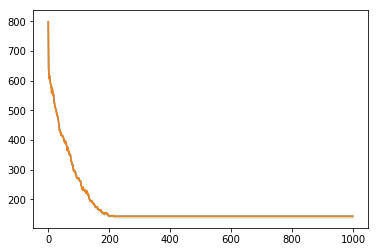

In [1930]:
score2 = [get_score(pred, y_train) for pred in gbt2.staged_predict(x_train)]
plt.plot([get_score(pred, y_train) for pred in gbt.staged_predict(x_train)])
plt.plot(score2)
plt.fill_between(xrange(len(score2)), np.array(score2) -np.mean(score2) * 0.03, 
                 np.array(score2) + np.mean(score2) * 0.03, alpha=0.1, color="g")

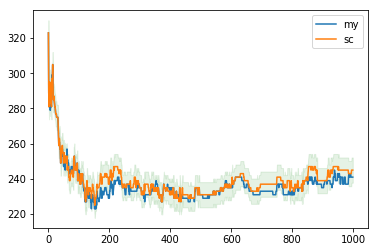

In [1931]:
score2 = [get_score(pred, y_test) for pred in gbt2.staged_predict(x_test)]
plt.plot([get_score(pred, y_test) for pred in gbt.staged_predict(x_test)],label='my')
plt.plot(score2, label='sc')
plt.fill_between(xrange(len(score2)), np.array(score2) -np.mean(score2) * 0.03, 
                 np.array(score2) + np.mean(score2) * 0.03, alpha=0.1, color="g")
plt.legend()

### spam dataset

In [16]:
df = pd.read_csv('./spam.train.txt', sep=' ', header=None)

In [17]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
0,1,0.349723,0.658872,0.341822,0.369098,0.448115,0.327417,0.517556,0.393646,0.430504,...,0.470654,0.410545,0.590262,0.450158,0.443301,0.467284,0.438850,0.413235,0.433625,0.575691
1,1,0.320356,0.214419,0.796892,0.283771,0.429499,0.336705,0.209530,0.411694,0.620735,...,0.470654,0.410545,0.454687,0.450158,0.443301,0.467284,0.438850,0.413235,0.433625,0.354707
2,1,0.575150,0.658872,0.341822,0.541797,0.430258,0.575468,0.509843,0.518629,0.383852,...,0.470654,0.410545,0.454687,0.450158,0.443301,0.467284,0.992203,0.768557,0.433625,0.391791
3,1,0.349723,0.658872,0.341822,0.440102,0.455950,0.327417,0.560001,0.398133,0.376336,...,0.470654,0.410545,0.607055,0.450158,0.443301,0.467284,0.438850,0.413235,0.433625,0.550478
4,1,0.320356,0.658872,0.341822,0.385197,0.437169,0.709301,0.419971,0.288835,0.382394,...,0.470654,0.410545,0.454687,0.450158,0.443301,0.467284,0.438850,0.413235,0.433625,0.741449


In [18]:
df[0].value_counts()

1    4123
0    2970
Name: 0, dtype: int64

In [19]:
x_train = np.array(df.drop([0], axis=1))

In [20]:
x_train.shape

(7093, 102)

In [21]:
y_train = np.array(df[0])
y_train = 2*y_train - 1

In [1973]:
gbt = GBoosting(max_depth=5, n_iters=1000, lr=0.1)

In [1974]:
%time gbt.fit(x_train, y_train)

iter 999CPU times: user 7min 18s, sys: 10.2 s, total: 7min 28s
Wall time: 7min 29s


In [1975]:
gbt2 = GradientBoostingClassifier(max_depth=5, criterion='mse', n_estimators=1000, init=BernoulliConst(), learning_rate=0.1)

In [1976]:
%time gbt2.fit(x_train, y_train)

CPU times: user 41.9 s, sys: 62.3 ms, total: 41.9 s
Wall time: 42 s


GradientBoostingClassifier(criterion='mse',
              init=<__main__.BernoulliConst object at 0x1397d2a10>,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

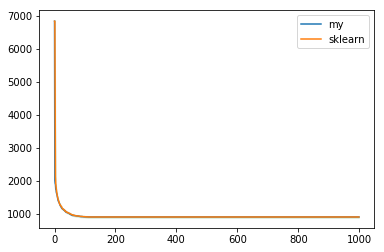

In [1977]:
score1 = [get_score(pred, y_train) for pred in gbt.staged_predict(x_train)]
score2 = [get_score(pred, y_train) for pred in gbt2.staged_predict(x_train)]
plt.plot(score1, label='my')
plt.plot(score2, label='sklearn')
plt.fill_between(xrange(len(score2)), np.array(score2) -np.mean(score2) * 0.03, 
                 np.array(score2) + np.mean(score2) * 0.03, alpha=0.1, color="g")
plt.legend()

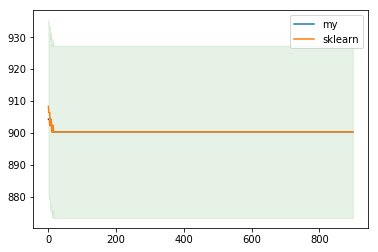

In [1978]:
plt.plot(score1[100:], label='my')
plt.plot(score2[100:], label='sklearn')
plt.fill_between(xrange(len(score2[100:])), np.array(score2[100:]) -np.mean(score2[100:]) * 0.03, 
                 np.array(score2[100:]) + np.mean(score2[100:]) * 0.03, alpha=0.1, color="g")
plt.legend()

In [22]:
df_test = pd.read_csv('./spam.test.txt', sep=' ', header=None)

In [23]:
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
0,1,0.445622,0.632602,0.368683,0.728974,0.479510,0.471833,0.571882,0.579280,0.604702,...,0.462762,0.448051,0.446374,0.424879,0.472828,0.450815,0.427943,0.416184,0.446429,0.667609
1,1,0.296747,0.632602,0.368683,0.330429,0.374055,0.451231,0.249144,0.431370,0.344248,...,0.462762,0.448051,0.916790,0.424879,0.472828,0.368804,0.464272,0.400264,0.547989,0.580435
2,1,0.296747,0.632602,0.368683,0.309466,0.392561,0.458103,0.289492,0.595944,0.574234,...,0.462762,0.448051,0.798868,0.424879,0.472828,0.368804,0.472316,0.415417,0.446429,0.781863
3,1,0.296747,0.184437,0.831801,0.239714,0.494042,0.716275,0.295862,0.349747,0.434139,...,0.462762,0.448051,0.446374,0.424879,0.472828,0.368804,0.427943,0.854188,0.543903,0.562639
4,1,0.368046,0.632602,0.368683,0.280957,0.380190,0.445567,0.339384,0.534049,0.522703,...,0.462762,0.448051,0.446374,0.533793,0.472828,0.812761,0.473772,0.400264,0.446429,0.659760


In [24]:
df_test[0].value_counts()

1    8023
0    2033
Name: 0, dtype: int64

In [25]:
x_test = np.array(df_test.drop([0], axis=1))

In [26]:
y_test = np.array(df_test[0])
y_test = 2*y_test - 1

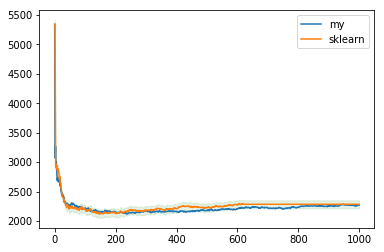

In [1979]:
score1 = [get_score(pred, y_test) for pred in gbt.staged_predict(x_test)]
score2 = [get_score(pred, y_test) for pred in gbt2.staged_predict(x_test)]
plt.plot(score1,label='my')
plt.plot(score2, label='sklearn')
plt.fill_between(xrange(len(score2)), np.array(score2) -np.mean(score2) * 0.03, 
                 np.array(score2) + np.mean(score2) * 0.03, alpha=0.1, color="g")
plt.legend()

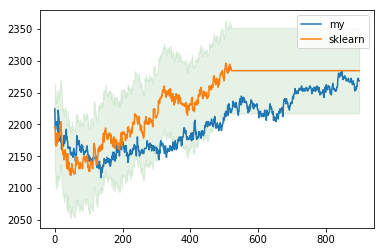

In [1980]:
score1 = score1[100:]
score2 = score2[100:]
plt.plot(score1,label='my')
plt.plot(score2, label='sklearn')
plt.fill_between(xrange(len(score2)), np.array(score2) -np.mean(score2) * 0.03, 
                 np.array(score2) + np.mean(score2) * 0.03, alpha=0.1, color="g")
plt.legend()

### Stacking

In [29]:
from sklearn.cross_validation import KFold

In [34]:
class MeanModel(object):
    def fit(self, x, y):
        pass

    @staticmethod
    def predict(x):
        return np.array(np.mean(x, axis=1) > 0.5, dtype=int)


class Stack(object):
    def __init__(self, meta_model=MeanModel(), models=[]):
        self.models = models
        self.meta_model = meta_model

    def fit(self, x, y, n_folds=3):
        folds = KFold(x.shape[0], n_folds)
        meta_features = np.zeros((x.shape[0], len(self.models)))
        
        for base_index, meta_index in folds:
            x_base, y_base = x[base_index], y[base_index]
            x_meta, y_meta = x[meta_index], y[meta_index]

            for i, model in enumerate(self.models):
                print "fold", i
                model.fit(x_base, y_base)
                meta_features[meta_index, i] = model.predict(x_meta)
            
        self.meta_model.fit(meta_features, y)
        for model in self.models:
            model.fit(x, y)
             
        return self
    
    def predict(self, x):
        meta_features = np.zeros((x.shape[0], len(self.models)))
        for i, model in enumerate(self.models):
            meta_features[:, i] = model.predict(x)
        return self.meta_model.predict(meta_features)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [51]:
logreg = LogisticRegression(C=0.5)

In [52]:
neur = MLPClassifier()

In [53]:
gbt = GradientBoostingClassifier(max_depth=5, n_estimators=500)

In [54]:
st = Stack(meta_model=LogisticRegression(C=0.1), models=[gbt, logreg, neur])

In [55]:
print x_train.shape, x_test.shape

(7093, 102) (10056, 102)


In [56]:
st.fit(x_train, y_train)

fold 0
fold 1
fold 2
fold 0
fold 1
fold 2
fold 0
fold 1
fold 2


In [57]:
roc_auc_score(y_train, st.predict(x_train))

1.0

In [58]:
for model in st.models:
    print roc_auc_score(y_train, model.predict(x_train))

1.0
0.951385060893
0.954422509516


In [59]:
roc_auc_score(y_test, st.predict(x_test))

0.93108597827973549

In [60]:
for model in st.models:
    print roc_auc_score(y_test, model.predict(x_test))

0.93108597828
0.921612905935
0.923935483321


In [61]:
f1_score(y_test, st.predict(x_test))

0.96932515337423308

In [62]:
for model in st.models:
    print f1_score(y_test, model.predict(x_test))

0.969325153374
0.936337437778
0.939986953686
